In [1]:
# Python packages
import scanpy as sc
# import scvi
import bbknn
import scib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

# R interface
from rpy2.robjects import pandas2ri
from rpy2.robjects import r
import rpy2.rinterface_lib.callbacks
import anndata2ri

pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

/data/cephfs-1/home/users/cemo10_c/work/miniconda/envs/integration/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:263: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/data/cephfs-1/home/users/cemo10_c/work/miniconda/envs/integration/lib/python3.9/site-packages/rpy2/robjects/numpy2ri.py:205: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '


In [2]:
adata = sc.read_h5ad("/data/cephfs-1/home/users/cemo10_c/work/scRNA/scRNA_preprocessing_pipeline/results/preprocessing/merged_manually.h5ad")
adata

AnnData object with n_obs × n_vars = 113995 × 11346
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'scDblFinder_score', 'scDblFinder_class', 'size_factors', 'leiden', 'leiden_res0_25', 'leiden_res0_5', 'leiden_res1', 'leiden_1', 'leiden_2', 'CMS1_score', 'CMS2_score', 'CMS3_score', 'CMS4_score', 'CMS', 'celltypist_cell_label_coarse', 'celltypist_conf_score_coarse', 'celltypist_cell_label_fine', 'celltypist_conf_score_fine', 'treatment', 'week', 'sample'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    layers: 'analytic_pearson_residuals', 'counts', 'log1p_norm', 'scran_normalization', 'soupX_counts'

In [3]:
adata.X = adata.layers["counts"].copy()

Let’s have a look at the different batches and how many cells we have for each.

In [4]:
batch_key = "sample"
adata.obs[batch_key].value_counts()

OnOff_2    9837
Conti_1    9559
OnOff_5    9342
C_1        9008
Conti_3    8800
OnOff_3    8668
C_4        8047
C_3        7809
Conti_4    7591
OnOff_1    7478
C_5        7075
C_2        6787
Conti_2    6668
OnOff_4    6030
Conti_5    1296
Name: sample, dtype: int64

# Unintegrated data

It is always recommended to look at the raw data before performing any integration. This can give some indication of how big any batch effects are and what might be causing them (and therefore which variables to consider as the batch label). For some experiments, it might even suggest that integration is not required if samples already overlap. This is not uncommon for mouse or cell line studies from a single lab for example, where most of the variables which contribute to batch effects can be controlled (i.e. the batch correction setting).

We will perform highly variable gene (HVG) selection, PCA and UMAP dimensionality reduction as we have seen in previous chapters.

In [16]:
sc.tl.pca(adata, n_comps = 100)

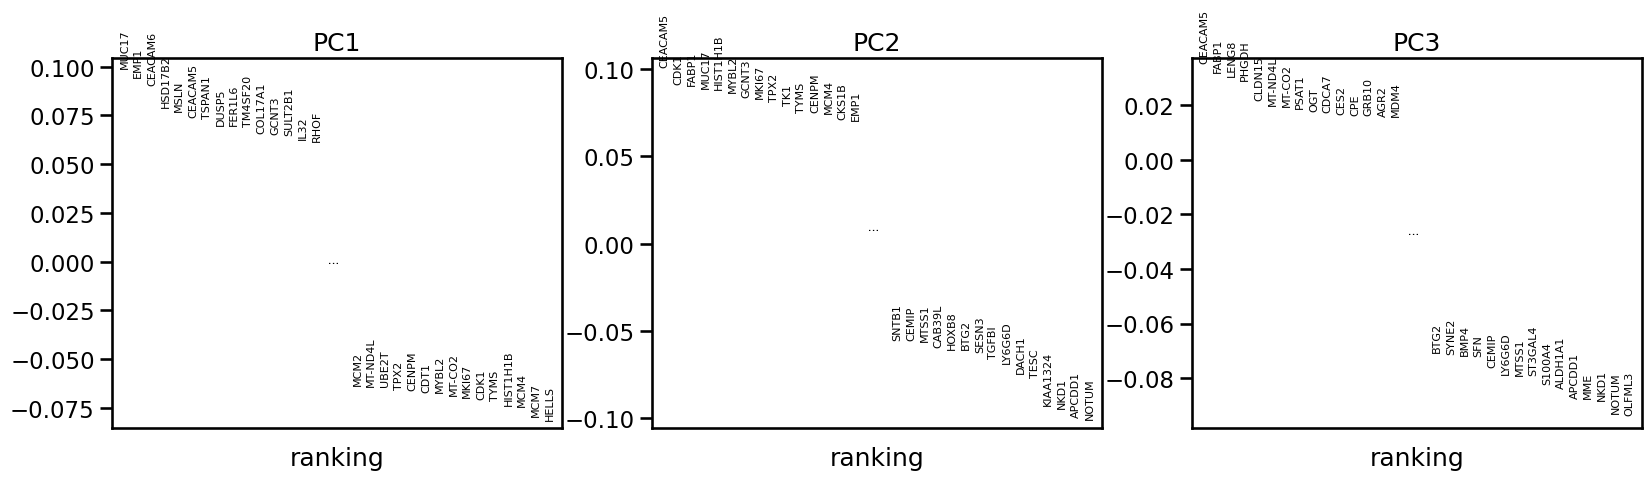

In [32]:
sc.pl.pca_loadings(adata)

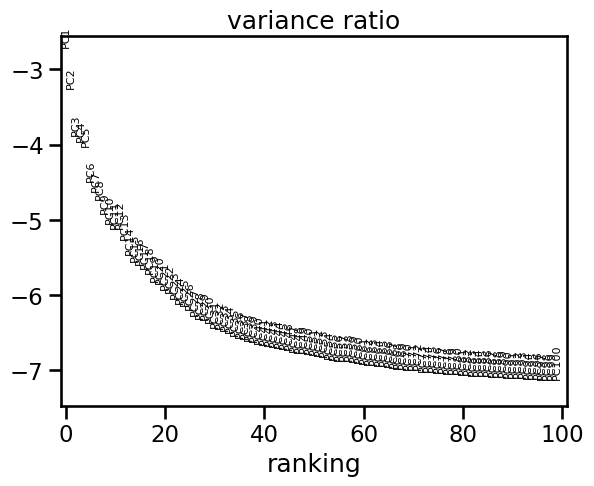

In [ ]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 100)

/data/cephfs-1/home/users/cemo10_c/work/miniconda/envs/integration/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/data/cephfs-1/home/users/cemo10_c/work/miniconda/envs/integration/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


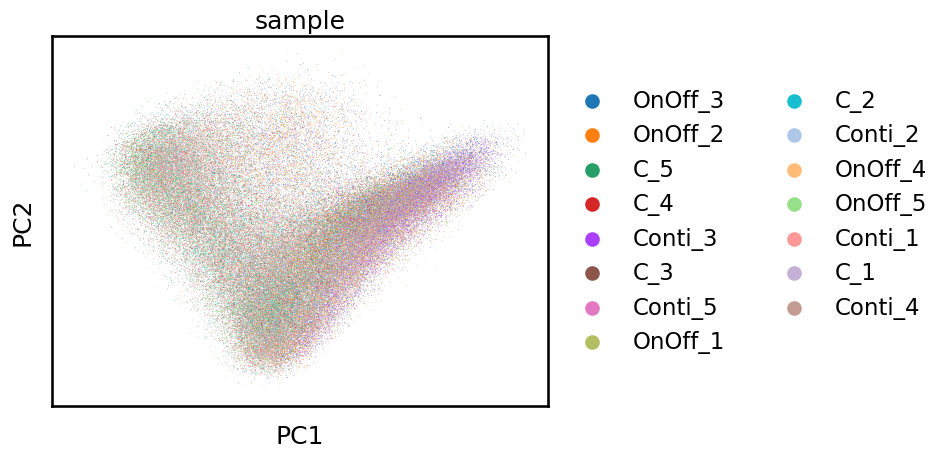

In [33]:
sc.pl.pca(adata, projection = "2d", color = batch_key)

/data/cephfs-1/home/users/cemo10_c/work/miniconda/envs/integration/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/data/cephfs-1/home/users/cemo10_c/work/miniconda/envs/integration/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:325: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = ax.scatter(


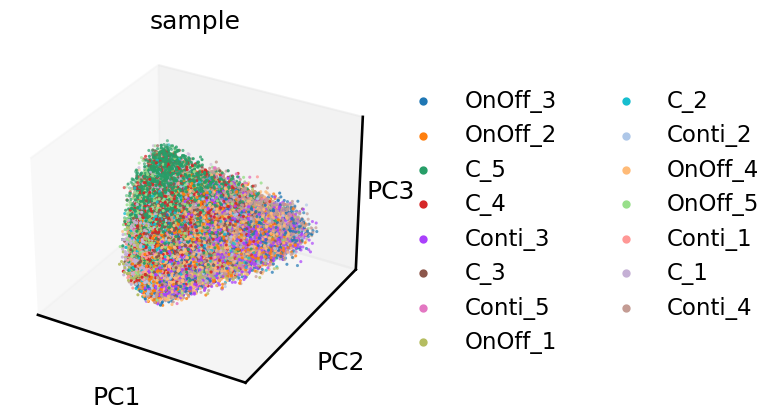

In [40]:
sc.pl.pca(adata, projection = "3d", color = batch_key)

In [41]:
sc.pp.highly_variable_genes(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs = 50)
sc.tl.umap(adata, n_components=3)
adata

/data/cephfs-1/home/users/cemo10_c/work/miniconda/envs/integration/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/data/cephfs-1/home/users/cemo10_c/work/miniconda/envs/integration/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/data/cephfs-1/home/users/cemo10_c/work/miniconda/envs/integration/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please u

AnnData object with n_obs × n_vars = 113995 × 11346
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'scDblFinder_score', 'scDblFinder_class', 'size_factors', 'leiden', 'leiden_res0_25', 'leiden_res0_5', 'leiden_res1', 'leiden_1', 'leiden_2', 'CMS1_score', 'CMS2_score', 'CMS3_score', 'CMS4_score', 'CMS', 'celltypist_cell_label_coarse', 'celltypist_conf_score_coarse', 'celltypist_cell_label_fine', 'celltypist_conf_score_fine', 'treatment', 'week', 'sample'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'pca', 'neighbors', 'umap', 'sample_colors', 'week_colors', 'treatment_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'analytic_pearson_

This adds several new items to our AnnData object. The var slot now includes means, dispersions and the selected variable genes. In the obsp slot we have distances and connectivities for our KNN graph and in obsm are the PCA and UMAP embeddings.

Let’s plot the UMAP, colouring the points by cell identity and batch labels. If the dataset had not already been labelled (which is often the case) we would only be able to consider the batch labels.

All samples.

/data/cephfs-1/home/users/cemo10_c/work/miniconda/envs/integration/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/data/cephfs-1/home/users/cemo10_c/work/miniconda/envs/integration/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:325: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = ax.scatter(


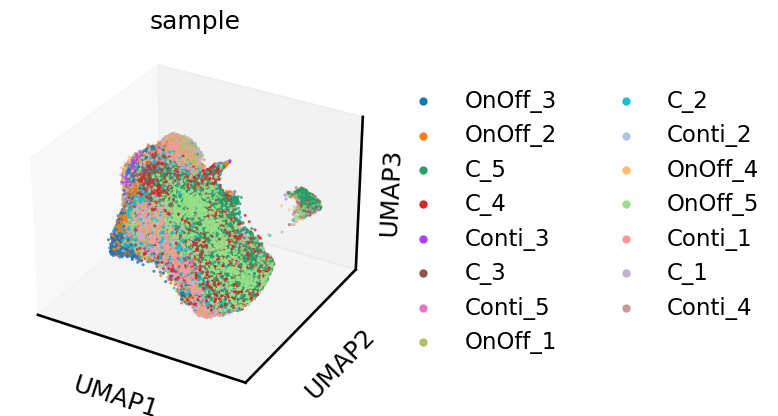

In [53]:
sc.pl.umap(adata, color=batch_key, projection="3d")

In [55]:
sc.tl.umap(adata, n_components=2)

/data/cephfs-1/home/users/cemo10_c/work/miniconda/envs/integration/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/data/cephfs-1/home/users/cemo10_c/work/miniconda/envs/integration/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


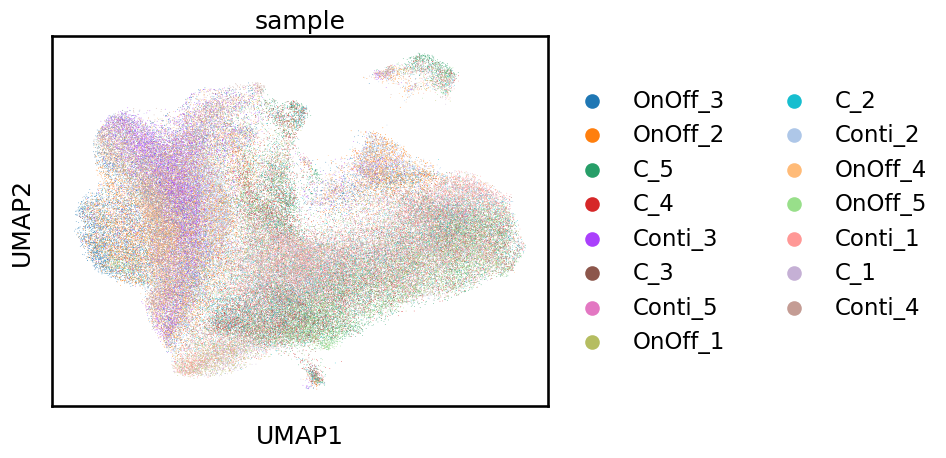

In [56]:
sc.pl.umap(adata, color=batch_key)

/data/cephfs-1/home/users/cemo10_c/work/miniconda/envs/integration/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/data/cephfs-1/home/users/cemo10_c/work/miniconda/envs/integration/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/data/cephfs-1/home/users/cemo10_c/work/miniconda/envs/integration/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


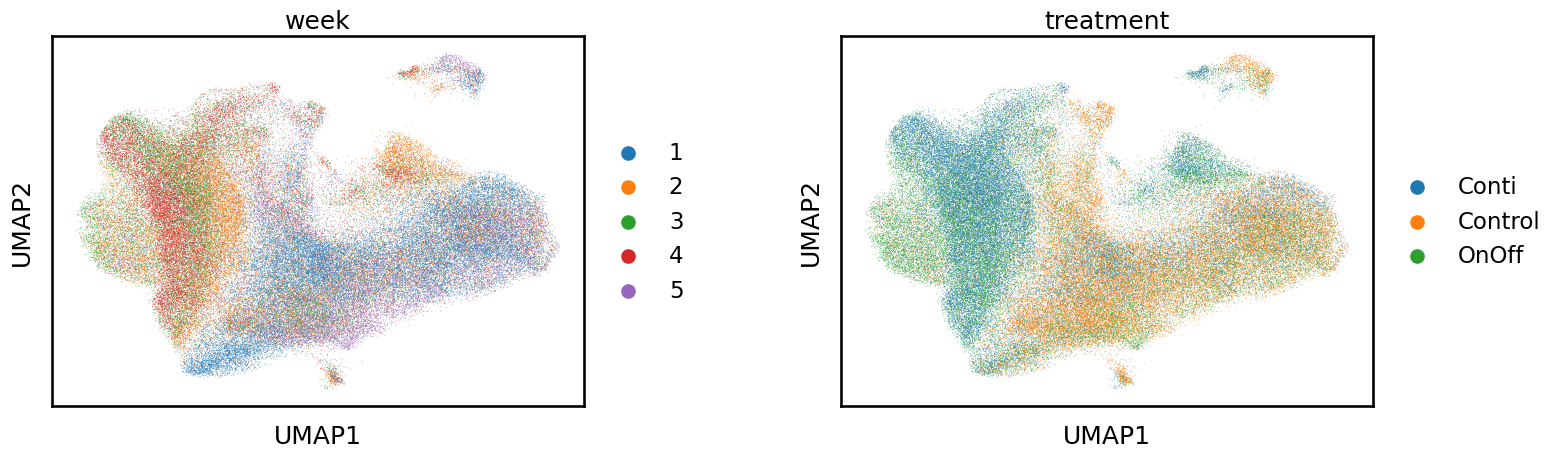

In [50]:
sc.pl.umap(adata, color=["week", "treatment"], wspace = 0.35)

Only first week. They should be near-identical.

/data/cephfs-1/home/users/cemo10_c/work/miniconda/envs/integration/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/data/cephfs-1/home/users/cemo10_c/work/miniconda/envs/integration/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


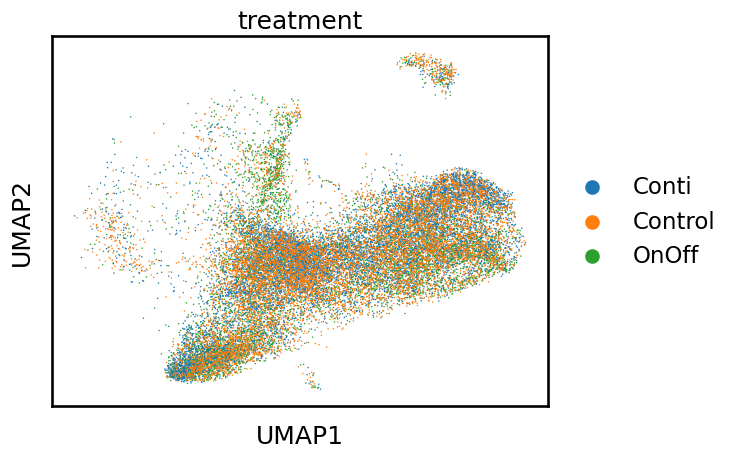

In [48]:
# plot umap of only week 1
sc.pl.umap(adata[adata.obs["week"] == "1"], color=["treatment"])

Only control. The different time points should not be too different.

/data/cephfs-1/home/users/cemo10_c/work/miniconda/envs/integration/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/data/cephfs-1/home/users/cemo10_c/work/miniconda/envs/integration/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


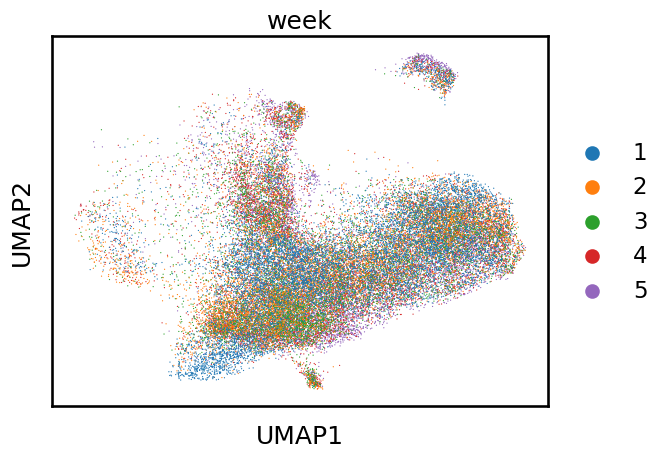

In [47]:
# plt umap of only treatment group control
sc.pl.umap(adata[adata.obs["treatment"] == "Control"], color=["week"])

Only continuous. They should be quite dissimilar, at least the first from the other weeks.

/data/cephfs-1/home/users/cemo10_c/work/miniconda/envs/integration/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/data/cephfs-1/home/users/cemo10_c/work/miniconda/envs/integration/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


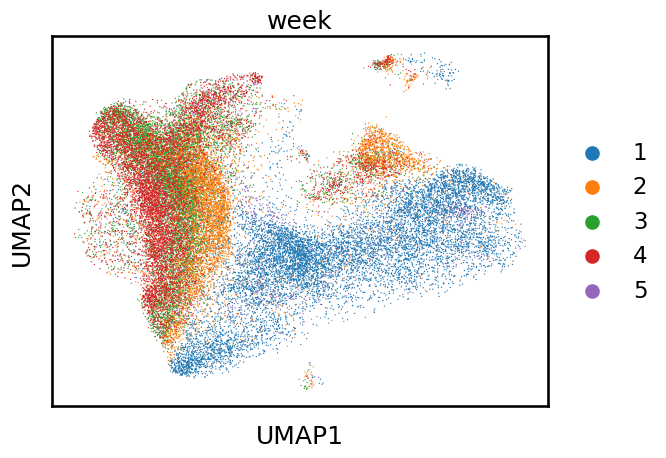

In [46]:
sc.pl.umap(adata[adata.obs["treatment"] == "Conti"], color=["week"])

Only OnOff. They should be quite dissimilar, at least the first from the other weeks.

/data/cephfs-1/home/users/cemo10_c/work/miniconda/envs/integration/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/data/cephfs-1/home/users/cemo10_c/work/miniconda/envs/integration/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


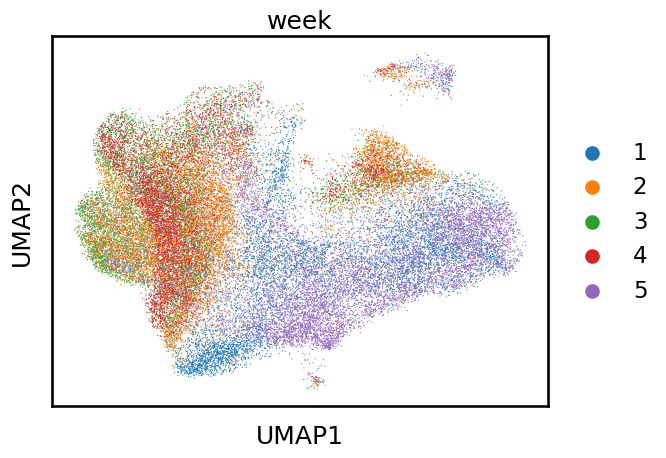

In [45]:
sc.pl.umap(adata[adata.obs["treatment"] == "OnOff"], color=["week"])

It looks like batch effect correction is not required and it might mask the biological variation of interest if still done.

# Clustering

In [58]:
sc.tl.leiden(adata, key_added="all_leiden_res0_25", resolution=0.25)
sc.tl.leiden(adata, key_added="all_leiden_res0_5", resolution=0.5)
sc.tl.leiden(adata, key_added="all_leiden_res1", resolution=1.0)

/data/cephfs-1/home/users/cemo10_c/work/miniconda/envs/integration/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/data/cephfs-1/home/users/cemo10_c/work/miniconda/envs/integration/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/data/cephfs-1/home/users/cemo10_c/work/miniconda/envs/integration/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/data/cephfs-1/home/users/cemo10_c/work/miniconda/envs/integration/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for 

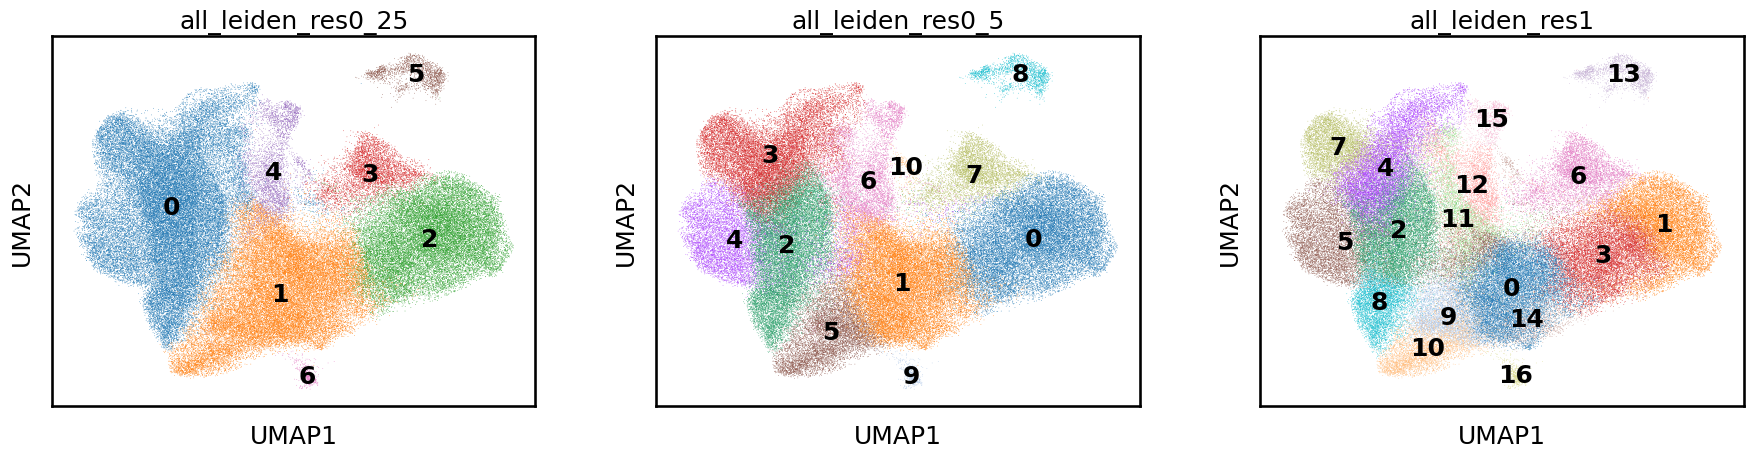

In [59]:
sc.pl.umap(
    adata,
    color=["all_leiden_res0_25", "all_leiden_res0_5", "all_leiden_res1"],
    legend_loc="on data",
)

Resolution 1 is results in too many small and some almost undistinguishable clusters (e.g. 0 vs 14).
The clustering from the other resolutions 0.25 and 0.5 are more reasonable, but it is difficult to choose among them or a resolution between them.

# More dimensional reduction methods

Visualizing scRNA-seq data is the process of projecting a high-dimensional matrix of cells and genes into a few coordinates such that every cell is meaningfully represented in a two-dimensional graph. However, the visualization of scRNA-seq data is an active area of research and each method defines 'meaningful' in its own way. Thus, it is a good idea to look at several visualizations and decide which visualization best represents the aspect of the data that is being investigated. 

Overall t-SNE visualizations have been very popular in the community, however the recent UMAP algorithm has been shown to better represent the topology of the data.

> Note that we do not scale the genes to have zero mean and unit variance. A lack of rescaling is equivalent to giving genes with a higher mean expression a higher weight in dimensionality reduction (despite correcting for mean offsets in PCA, due to the mean-variance relationship). We argue that this weighting based on mean expression being a biologically relevant signal. However, rescaling HVG expression is also common, and the number of publications that use this approach suggests that scaling is at least not detrimental to downstream scRNA-seq analysis.

The same is done in this notebook.

In [ ]:
sc.tl.tsne(adata, n_jobs=12)
sc.tl.diffmap(adata)

In [65]:
sc.tl.draw_graph(adata)

In [67]:
adata

AnnData object with n_obs × n_vars = 113995 × 11346
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'scDblFinder_score', 'scDblFinder_class', 'size_factors', 'leiden', 'leiden_res0_25', 'leiden_res0_5', 'leiden_res1', 'leiden_1', 'leiden_2', 'CMS1_score', 'CMS2_score', 'CMS3_score', 'CMS4_score', 'CMS', 'celltypist_cell_label_coarse', 'celltypist_conf_score_coarse', 'celltypist_cell_label_fine', 'celltypist_conf_score_fine', 'treatment', 'week', 'sample', 'all_leiden_res0_25', 'all_leiden_res0_5', 'all_leiden_res1'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'pca', 'neighbors', 'umap', 'sample_colors', 'week_colors', 'treatment_colors', 'leiden', 'all_leiden

/data/cephfs-1/home/users/cemo10_c/work/miniconda/envs/integration/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/data/cephfs-1/home/users/cemo10_c/work/miniconda/envs/integration/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


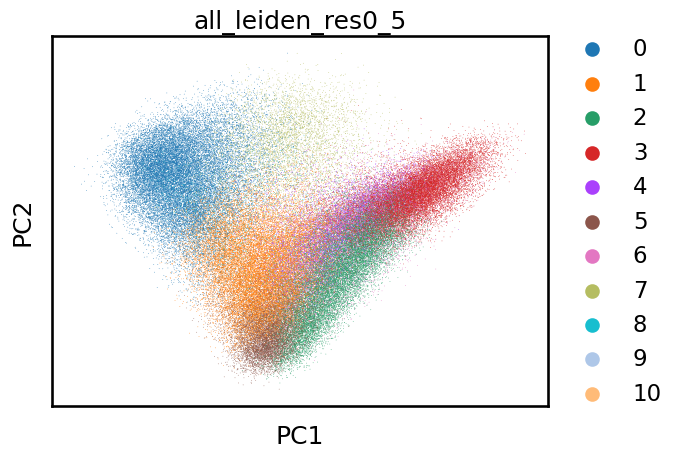

/data/cephfs-1/home/users/cemo10_c/work/miniconda/envs/integration/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/data/cephfs-1/home/users/cemo10_c/work/miniconda/envs/integration/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


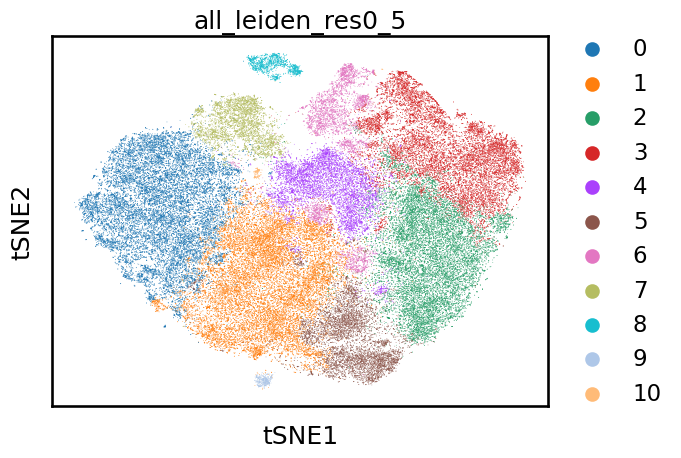

/data/cephfs-1/home/users/cemo10_c/work/miniconda/envs/integration/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/data/cephfs-1/home/users/cemo10_c/work/miniconda/envs/integration/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


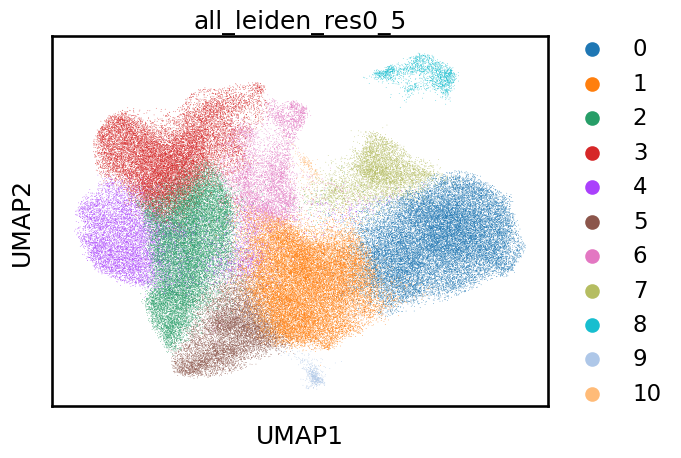

/data/cephfs-1/home/users/cemo10_c/work/miniconda/envs/integration/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/data/cephfs-1/home/users/cemo10_c/work/miniconda/envs/integration/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/data/cephfs-1/home/users/cemo10_c/work/miniconda/envs/integration/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


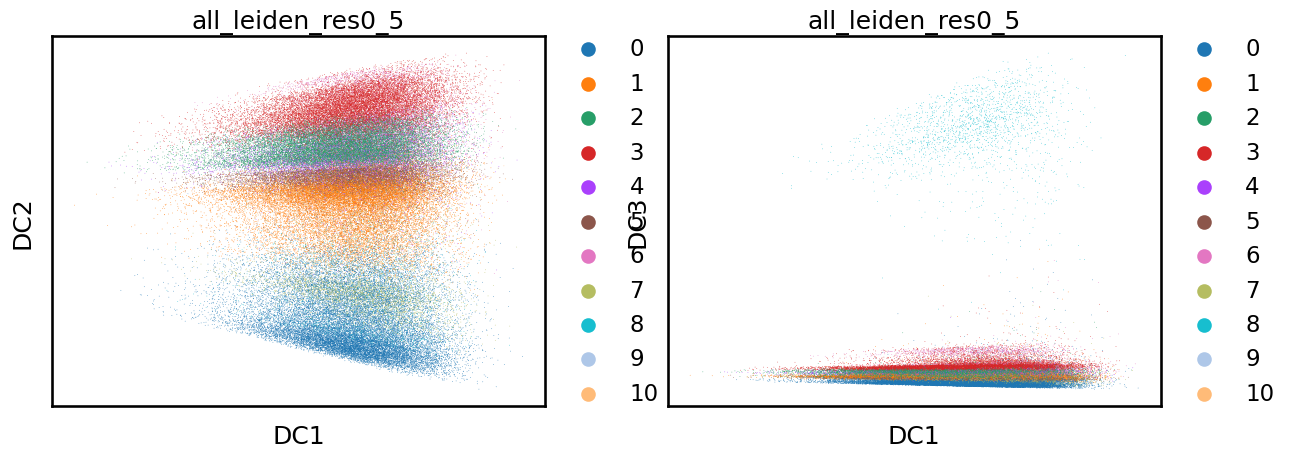

/data/cephfs-1/home/users/cemo10_c/work/miniconda/envs/integration/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/data/cephfs-1/home/users/cemo10_c/work/miniconda/envs/integration/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


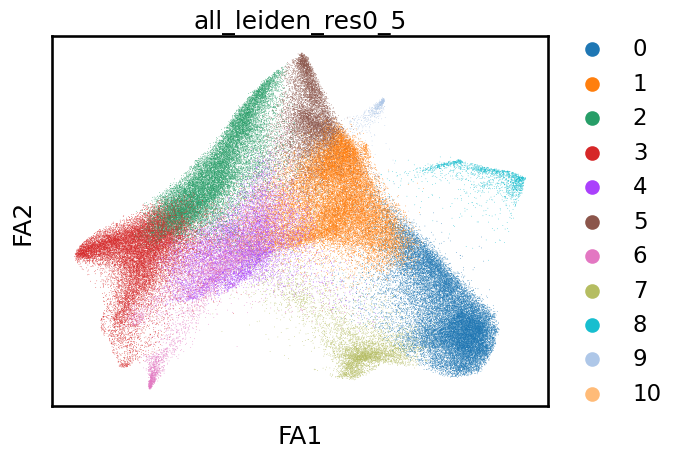

In [71]:
color_key = 'all_leiden_res0_5'
sc.pl.pca_scatter(adata, color=color_key)
sc.pl.tsne(adata, color=color_key)
sc.pl.umap(adata, color=color_key)
sc.pl.diffmap(adata, color=color_key, components=['1,2','1,3'])
sc.pl.draw_graph(adata, color=color_key)

In [57]:
# save to file
adata.write('/data/cephfs-1/work/groups/cubi/users/cemo10_c/scRNA/scRNA_preprocessing_pipeline/results/preprocessing/merged_dim_reduc_based_on_count.h5ad')